In [2]:
%config Completer.use_jedi = False

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [10,8]

In [4]:
!wget -O ../data/raw/AB_NYC_2019-hw2.csv https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv

--2021-09-19 18:48:07--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv
Resolviendo raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Conectando con raw.githubusercontent.com (raw.githubusercontent.com)[185.199.109.133]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 7077973 (6,8M) [text/plain]
Guardando como: “../data/raw/AB_NYC_2019-hw2.csv”

../data/raw/AB_NYC_ 100%[===================>]   6,75M  11,9MB/s    en 0,6s    

2021-09-19 18:48:08 (11,9 MB/s) - “../data/raw/AB_NYC_2019-hw2.csv” guardado [7077973/7077973]



### EDA

* Load the data.
* Look at the `price` variable. Does it have a long tail? 

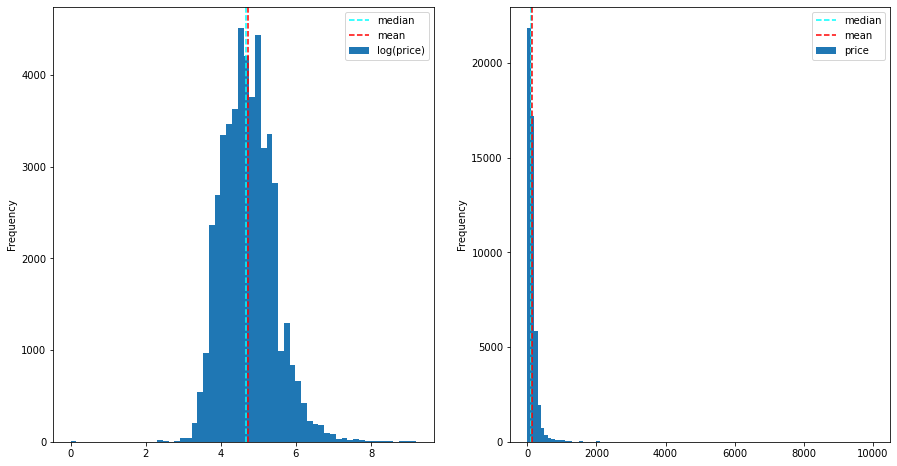

In [5]:
df = pd.read_csv('../data/raw/AB_NYC_2019-hw2.csv', index_col=['id']).reset_index('id', drop=True)
fig, axes = plt.subplots(1,2, figsize=(15,8))

log_prices = np.log1p(df.price.copy())
prices = df.price.copy()

log_prices.plot.hist(bins=60, ax=axes[0], label="log(price)")
axes[0].axvline(x=log_prices.median(), color="cyan", linestyle="--", label="median")
axes[0].axvline(x=log_prices.mean(), color="red", linestyle="--", label="mean")
axes[0].legend()


prices.plot.hist(bins=100, ax=axes[1])
axes[1].axvline(x=prices.median(), color="cyan", linestyle="--", label="median")
axes[1].axvline(x=prices.mean(), color="red", linestyle="--", label="mean")
axes[1].legend()


In [6]:
# NOTES: 
# asymmetry
# mean < median: left tail 
# mean > median: right tail

# kurtosis: describes the peakedness of the distribution.
# Si kurtosis<3 la distribución es Platicúrtica
# Si kurtosis=3 la distribución es Mesocúrtica
# Si kurtosis>3 la distribución es Leptocúrtica
#  High kurtosis in a data set is an indicator that data has heavy outliers.
#  Low kurtosis in a data set is an indicator that data has lack of outliers.

# skew: Skewness is a measure of asymmetry of a distribution.
# When a distribution is asymmetrical the tail of the distribution is skewed to one side-to the right or to the left.
# When the value of the skewness is negative, the tail of the distribution is longer towards the left hand side of the curve.
# When the value of the skewness is positive, the tail of the distribution is longer towards the right hand side of the curve
#  If the skewness is between -0.5 and 0.5, the data are fairly symmetrical
#  If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed
#  If the skewness is less than -1 or greater than 1, the data are highly skewed


# Skewness essentially measures the symmetry of the distribution, while kurtosis determines the heaviness of the distribution tails.
# REF1: https://medium.com/@atanudan/kurtosis-skew-function-in-pandas-aa63d72e20de
# REF2: https://www.odiolaestadistica.com/estadistica-python/asimetria/

In [7]:
def tail(values):
    data = {
        "skew": values.skew(), 
        "kurtosis": values.kurtosis(), 
        "tail": "left" if values.mean() < values.median() else "right"
    }
    
    if abs(values.skew()) <= 0.5: 
        data['skewness'] = "fairly simmetrical"
    elif 0.5 < abs(values.skew()) < 1:
        data['skewness'] = "moderately skewed"
    else: 
        data['skewness'] = "highly skewed"
        
        
    if data['kurtosis'] < 3: 
        data['peak'] = "Platicúrtica"
    elif data['kurtosis'] == 3:
        data['peak'] = "Mesocúrtica"
    else: 
        data['peak'] = "Leptocúrtica"
        
    return data

In [8]:
print("Without log ", tail(prices))
print("With log ", tail(log_prices))

Without log  {'skew': 19.118938995046033, 'kurtosis': 585.6728788988286, 'tail': 'right', 'skewness': 'highly skewed', 'peak': 'Leptocúrtica'}
With log  {'skew': 0.5531045462041445, 'kurtosis': 1.7427227060507144, 'tail': 'right', 'skewness': 'moderately skewed', 'peak': 'Platicúrtica'}


### Answer: if we don't rescale price feature, it has a long right tail with a heavy peak.



### Features

For the rest of the homework, you'll need to use only these columns:

* `'latitude'`,
* `'longitude'`,
* `'price'`,
* `'minimum_nights'`,
* `'number_of_reviews'`,
* `'reviews_per_month'`,
* `'calculated_host_listings_count'`,
* `'availability_365'`

Select only them.

In [9]:
columns = ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', ]
df = df[columns]

### Question 1

Find a feature with missing values. How many missing values does it have?

In [10]:
df.isna().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [11]:
### Answer 1: reviews_per_month has 10052 missing values

### Question 2

What's the median (50% percentile) for variable 'minimum_nights'?

In [12]:
"Median of minimum_nights is %s" % df.minimum_nights.median()

'Median of minimum_nights is 3.0'

### Split the data

* Shuffle the initial dataset, use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Make sure that the target value ('price') is not in your dataframe.
* Apply the log transformation to the price variable using the `np.log1p()` function.

In [13]:

#Shuffle the initial dataset, use seed `42`.
np.random.seed(42)
features = df.columns[~df.columns.isin(['price', 'price_log'])]

def data_ingestion(df):
    df = df.copy()
    
    # Apply the log transformation to the price variable using the np.log1p() function.
    df['price_log'] = np.log1p(df.price)

    # Split your data in train/val/test sets, with 60%/20%/20% distribution.
    n = df.shape[0]
    n_test = round(n * 0.2)
    n_train = n - 2 * n_test

    idx = np.arange(n)
    np.random.shuffle(idx)

#     print(f"Train size: {n_train} - Val size {n_test} - Test size:{n_test}")
    
    X = df[features]
    y = df[['price_log']]

    X_train = X.iloc[idx[:n_train]]
    X_val = X.iloc[idx[n_train:n_train+n_test]]
    X_test = X.iloc[idx[n_train+n_test:]]

    y_train = y.iloc[idx[:n_train]]
    y_val = y.iloc[idx[n_train:n_train+n_test]]
    y_test = y.iloc[idx[n_train+n_test:]]
    
    return X, y, X_train, X_val, X_test, y_train, y_val, y_test

(
    X, y, 
    X_train, X_val, X_test, 
    y_train, y_val, y_test 
) = data_ingestion(df)

# Make sure that the target value ('price') is not in your dataframe.
assert 'price' not in X.columns
assert 'price_log' in y.columns



### Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

In [14]:
minimum_nights_mean = X_train.minimum_nights.mean()

def prepare_X(df, mean=False):
    df = df.copy()
    
    if mean==False:
        df.reviews_per_month = df.reviews_per_month.fillna(0)
    else:
        df.reviews_per_month = df.reviews_per_month.fillna(minimum_nights_mean)
    
    return df

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)


In [15]:
assert prepare_X(X).reviews_per_month.isna().sum() == 0, "reviews_per_month must not have null values"
assert all(elem in prepare_X(X).columns for elem in features), "has all features"

In [46]:
class LinearModel:
    def __init__(self):
        self.w0 = 0
        self.w = np.array([])
        
    def train(self, X, y):
        X = X.copy().values
        ones = np.ones(X.shape[0])
        X = np.column_stack([ones, X])
        XTX = X.T.dot(X)
        XTX_inv = np.linalg.inv(XTX)
        w_full = XTX_inv.dot(X.T).dot(y)
        
        self.w0 =  w_full[0]
        self.w = w_full[1:]
    
    def predict(self, X):
        return (self.w0 + X.dot(self.w) ).rename(columns = {0:'prediction'})
    
    def __rmse(self, y, y_pred):
        se = (y - y_pred) ** 2
        mse = se.mean()
        return np.sqrt(mse)
    
    def score(self, X, y, rounded=2):
        return round(self.__rmse(y.values, self.predict(X).values), rounded)

In [47]:
model = LinearModel()
model_mean = LinearModel()

model.train(prepare_X(X_train, mean=False), y_train)
model_mean.train(prepare_X(X_train, mean=True), y_train)

In [62]:
score_with_0 = model.score(prepare_X(X_val), y_val,)
score_with_mean = model_mean.score(prepare_X(X_val, mean=True), y_val)

best_strategy = "" 
if score_with_0 < score_with_mean:
    best_strategy = 'with 0'
elif score_with_0 > score_with_mean:
    best_strategy = 'with mean'
else:
    best_strategy = 'same'
print(f">> Best way to fill NA's: { best_strategy }")
print(f"score with fillna(0): {score_with_0} - score with fillna(mean): {score_with_mean}")

>> Best way to fill NA's: same
score with fillna(0): 0.64 - score with fillna(mean): 0.64


### Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

In [49]:
class LinearModelRegularized(LinearModel):
    def __init__(self, r=0.0):
        self.w0 = 0
        self.w = np.array([])
        self.r = r
        
    def train(self, X, y, ):
        ones = np.ones(X.shape[0])
        X = np.column_stack([ones, X])
        XTX = X.T.dot(X)
        XTX = XTX + self.r * np.eye(XTX.shape[0])
        
        XTX_inv = np.linalg.inv(XTX)
        w_full = XTX_inv.dot(X.T).dot(y)
        
        self.w0 =  w_full[0]
        self.w = w_full[1:]
    

In [54]:
models = []
scores = [] 

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    model = LinearModelRegularized(r)
    model.train(prepare_X(X_train), y_train)
    models.append(model)
    scores.append((r, model.score(prepare_X(X_train), y_train, 3), model.score(prepare_X(X_val), y_val), 3))
    print(F"Reg: {r:09.6f}   =>   Train: {model.score(prepare_X(X_train), y_train):06.3f} - Val: {model.score(prepare_X(X_val), y_val):06.3f}")


Reg: 00.000000   =>   Train: 00.650 - Val: 00.640
Reg: 00.000001   =>   Train: 00.650 - Val: 00.640
Reg: 00.000100   =>   Train: 00.650 - Val: 00.640
Reg: 00.001000   =>   Train: 00.650 - Val: 00.640
Reg: 00.010000   =>   Train: 00.660 - Val: 00.650
Reg: 00.100000   =>   Train: 00.680 - Val: 00.680
Reg: 01.000000   =>   Train: 00.680 - Val: 00.680
Reg: 05.000000   =>   Train: 00.680 - Val: 00.680
Reg: 10.000000   =>   Train: 00.680 - Val: 00.680


### Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)


> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.

In [65]:
scores = []
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(seed)
    (
        X, y, 
        X_train, X_val, X_test, 
        y_train, y_val, y_test 
    ) = data_ingestion(df)
    
    model = LinearModel()
    model.train(prepare_X(X_train, mean=False), y_train)
    
    score_train = model.score(prepare_X(X_train, mean=False), y_train)
    score_val = model.score(prepare_X(X_val, mean=False), y_val)
    
    scores.append((seed, score_train, score_val))
    
    print(F"Seed: {seed} => Train: {score_train:06.2f} - Val: {score_val:06.2f}")

rmse_val_sets = list(map(lambda r: r[2], scores))
print(50*"_")
print(f" STD of RMSE list {round(np.std(rmse_val_sets),3)}")

# _ = plt.hist(rmse_val_sets, bins=5)

Seed: 0 => Train: 000.65 - Val: 000.65
Seed: 1 => Train: 000.64 - Val: 000.65
Seed: 2 => Train: 000.65 - Val: 000.65
Seed: 3 => Train: 000.65 - Val: 000.64
Seed: 4 => Train: 000.64 - Val: 000.64
Seed: 5 => Train: 000.65 - Val: 000.63
Seed: 6 => Train: 000.65 - Val: 000.63
Seed: 7 => Train: 000.64 - Val: 000.65
Seed: 8 => Train: 000.65 - Val: 000.65
Seed: 9 => Train: 000.65 - Val: 000.64
__________________________________________________
 STD of RMSE list 0.008


### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

In [58]:
np.random.seed(9)
(
    X, y, 
    X_train, X_val, X_test, 
    y_train, y_val, y_test 
) = data_ingestion(df)

X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

model = LinearModel()
model.train(prepare_X(X_train_full, mean=False), y_train_full)

score_test = model.score(prepare_X(X_train_full, mean=False), y_train_full, 3)
score_test = model.score(prepare_X(X_test, mean=False), y_test, 3)

print(F"Seed: {9} => Train: {score_train:06.3f} - Val: {score_test:06.3f}")

Seed: 9 => Train: 00.650 - Val: 00.645
